**Introduction to Information Extraction pipelines and Knowledge Graphs**

This instructional notebook demonstrates a simple spaCy-based information extraction pipeline that results in the construction of a basic knowledge graph.
It builds off of the lesson_4_spaCy.ipynb notebook which you should review first.
We'll attempt to parse a document containing characters from the Game of Thrones epic, perform entity extraction, and predict the relations between them using a distantly-supervised BERT model.

For some background, a knowledge graph (KG) represents a network of real-world entities—i.e. objects, events, situations, or concepts—and illustrates the relationship between them. This information is usually stored in a graph database and visualized as a graph structure. A KG is made up of three main components: nodes, edges, and labels. Any object, place, or person can be a node. An edge defines the relationship between the nodes.

Once a knowledge graph is complete, it allows question answering and search systems to retrieve and reuse comprehensive answers to given queries. In addition to being a machine-compatible representation of data, automatic KG creation and completion is also an active area of NLP research.

NB: We'll be working with a sample document that summarizes key characters in the GoT series. The document does not explicitly contain plot spoilers, although entities revealed in the knowledge graphs
may inadvertently reveal plot elements. Just go and watch the show or read the books if you haven't yet.

In [1]:
# Standard imports
import sys
import itertools
from tqdm import tqdm
import pandas as pd

# NLP dependencies
import re
import spacy
import opennre

# Network graph visualization depdendencies
import networkx as nx
import matplotlib.pyplot as plt

pd.set_option('display.max_colwidth', 200)
%matplotlib inline

<b> A few notes on dependencies </b>

At the moment, OpenNRE (used for relation prediction) is not available as a python package. You'll need to follow a few simple steps to install it from their [opennre github readme](https://github.com/thunlp/OpenNRE). In addition to the depedencies, you'll need to download a spacy language model compatible with your spaCy
version. 

In [2]:
print(spacy.__version__)

3.0.7


In [ ]:
# ensuring we install the compatible spaCy language model
!{sys.executable} -m pip install https://github.com/explosion/spacy-models/releases/download/en_core_web_lg-3.0.0/en_core_web_lg-3.0.0.tar.gz

<b> Part 0: Basic text preprocessing </b>

First we'll need to read in our raw text file and convert it into a spaCy document object.

In [3]:
nlp = spacy.load('en_core_web_lg') # load the large english language model

# Read in the document
file_name = "got_chars_v2" # from https://www.dummies.com/art-center/performing-arts/acting/game-of-thrones-characters-and-cast/
file_text = open(file_name).read()

# Strip out the actual actor names which are in parenthesis using the standard regex library
file_text = re.sub("[\(\[].*?[\)\]]", "", file_text)

# Convert the text into a spaCy document object
got_doc = nlp(file_text)

SpaCy has built-in sentence boundary detection to detect the span of the sentence.
We can use it to extract each sentence of our file and store them into a list, so we can perform entity and relation extraction one sentence at a time.
This of course is a bit simplistic and ignores relations that can span across the document. There may be other options
for doing document-level entity extraction available.

In [4]:
sentences = list(got_doc.sents)
print(f"Number of sentences: {len(sentences)}")

sents = []
[sents.append(str(sentence)) for sentence in sentences]
print("First five sentences:")
sents[0:5]

Number of sentences: 87
First five sentences:


['Eddard  Stark :',
 'Ned is the head of House Stark and Lord of Winterfell, the ancient castle fortress of the North.',
 'Ned is a good, honorable man who gets entangled in the corruption of King’s Landing, the seat of the Iron Throne.',
 'His struggles against that corruption lead to tragedy for himself and his family.',
 '\n\n']

<b> Part 1: KG creation using subject-verb-object triples </b>

Let's use spaCy's built-in dependency parser to extract a sentence's subject, verb, and object.
We'll assume that the subject and object are two entities or nodes, and the verb is the relationship or edge that relates the nodes.
This is of course a very narrow definition of "relationship", but provides a nice first pass at understanding our document.
The function below extracts the subject, verb, object triple and is taking from the lesson 4 spaCy walkthrough notebook.

In [5]:
# object and subject constants
OBJECT_DEPS = {"dobj", "dative", "attr", "oprd"}
SUBJECT_DEPS = {"nsubj", "nsubjpass", "csubj", "agent", "expl"}

# extract the subject, object and verb from the input
def extract_triples(doc):
    sub = []
    at = []
    ve = []
    for token in doc:
        # is this a verb?
        if token.pos_ == "VERB":
            ve.append(token.text)
        # is this the object?
        if token.dep_ in OBJECT_DEPS or token.head.dep_ in OBJECT_DEPS:
            at.append(token.text)
        # is this the subject?
        if token.dep_ in SUBJECT_DEPS or token.head.dep_ in SUBJECT_DEPS:
            sub.append(token.text)
    return " ".join(sub).strip().lower(), " ".join(ve).strip().lower(), " ".join(at).strip().lower()

Let's grab the s,v,o triples for each sentence, store them in separate lists,
and then combine the lists into a pandas dataframe to view the relationships
and make it easy for graph creation and visualization.

In [23]:
# Create empty lists to store all subject, verbs, and objects

subjects = []
verbs = []
objects = []

# Grab the SVOs from each sentence

for sent in sents:
    doc = nlp(sent)
    s,v,o = extract_triples(doc)
    subjects.append(s)
    verbs.append(v)
    objects.append(o)

# store them in a df
kg_df = pd.DataFrame({'source':subjects, 'target':objects, 'edge':verbs})
kg_df.sample(5)

,source,target,edge
53,he,the legitimate son of and heir,believed be
61,daenerys,the exiled daughter of,deposed surviving
15,she joffrey her father,a crush on robert hand of,develops travels betrothed becomes
46,tyrion there he tywin and cercei,a line cross — line no trouble crossing,is cross have crossing
20,arya,a tomboy sword fighting than,learn


SVO relationships work fairly well when they have simple predictable formulations.
However, the grammatical approach falls apart with more complex constructions and requires more adjustments to the SVO function logic.

Let's visualize the results as a directed graph.
Create a graph object from the [networkx library](https://networkx.org/documentation/stable/index.html).
For larger graphs that can't be stored in memory, you may want use Neo4j for scalability, although it has a steeper learning curve. We'll first need to create a graph object from the dataframe from the previous code block:

In [24]:
# create a directed graph from a dataframe
G=nx.from_pandas_edgelist(kg_df, "source", "target", 
                          edge_attr=True, create_using=nx.MultiDiGraph())

Use the draw methods to visualizing the relationships (verb linkages) between subjects and objects.

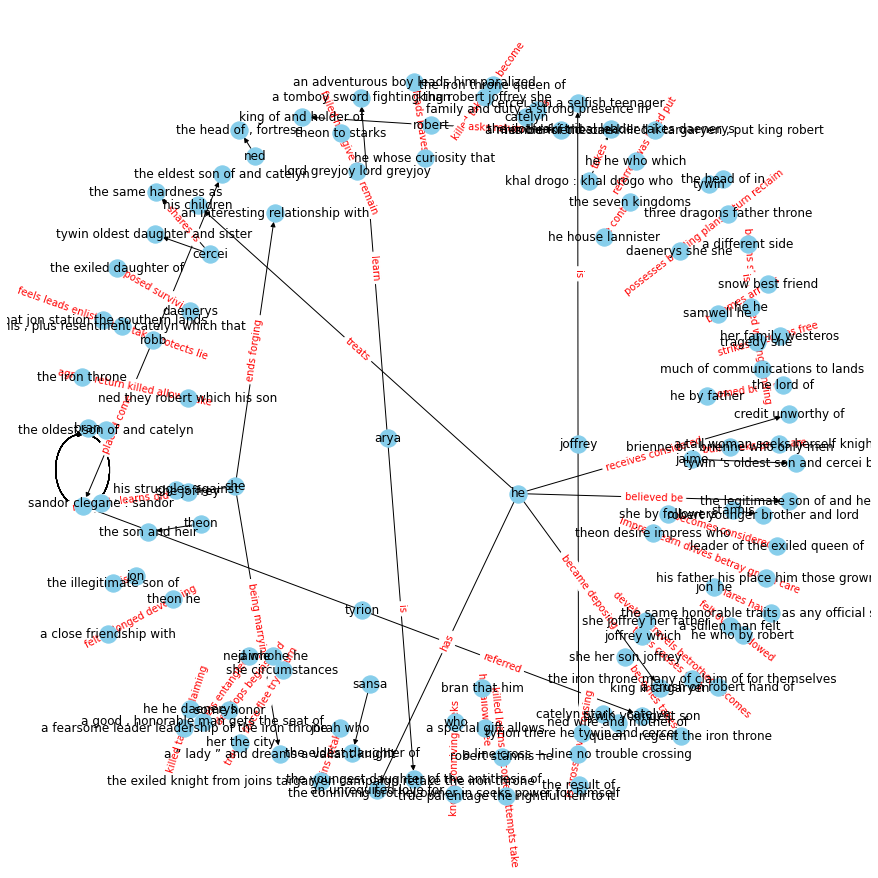

In [26]:
plt.figure(figsize=(12,12))

pos = nx.spring_layout(G)
nx.draw(G, with_labels=True, node_color='skyblue', edge_cmap=plt.cm.Blues, pos = pos)
edge_labels = nx.get_edge_attributes(G,'edge')

formatted_edge_labels = {(elem[0],elem[1]):edge_labels[elem] for elem in edge_labels} # use this to modify the tuple keyed dict if it has > 2 elements, else ignore
nx.draw_networkx_edge_labels(G,pos,edge_labels=formatted_edge_labels,font_color='red')
plt.show()

Clearly, the SVO method to creating KG "triples" is a very rough approach and requires standardization of relationships to be more useful. It also requires you to understand grammar rules to properly set up.
Let's try a less grammatical approach to KG creation.

<b> Part 2: KG creation using NER and relation prediction </b>

This time, we're going to try extracting entities from the document, and then use a pre-trained relation extraction model to predict the character relationships.
We'll work with SpaCy's built-in entity extraction capabilities and then use OpenNRE to predict relations.

First, a quick review on the various entity attributes you can pull out from spaCy:

In [27]:
# Named Entity Recognition (NER) - Taken from lesson4_spaCy_examples.ipynbspaCy 

for ent in got_doc.ents:
    print(ent.text, ent.start_char, ent.end_char,
        ent.label_, spacy.explain(ent.label_))

Eddard  Stark 0 13 PERSON People, including fictional
Ned 16 19 PERSON People, including fictional
House Stark 35 46 ORG Companies, agencies, institutions, etc.
Winterfell 59 69 PERSON People, including fictional
North 106 111 LOC Non-GPE locations, mountain ranges, bodies of water
Ned 113 116 PERSON People, including fictional
King’s Landing 182 196 ORG Companies, agencies, institutions, etc.
the Iron Throne 210 225 LOC Non-GPE locations, mountain ranges, bodies of water
Catelyn Stark 310 323 PERSON People, including fictional
Catelyn 326 333 PERSON People, including fictional
Ned 337 340 PERSON People, including fictional
five 366 370 CARDINAL Numerals that do not fall under another type
Catelyn 393 400 PERSON People, including fictional
Robb 591 595 PERSON People, including fictional
Westeros 614 622 PERSON People, including fictional
King’s Landing 646 660 ORG Companies, agencies, institutions, etc.
Robb Stark 663 673 PERSON People, including fictional
Robb 676 680 PERSON People, i

SpaCy's NER works really well out of the box!
It identifies the characters and families, the character position of the entities within the document object, and the entity type.
As an optional step, you may want to perform coreference resolution to narrow down entities that have multiple aliases and associations.
Hugging face's [Neuralcoref](https://spacy.io/universe/project/neuralcoref) module is a great neural-network based option for doing this and runs on top of spaCy.
(Note: Neuralcoref installation is finnicky; recommend using pip install with python 3.7 and spaCy 2.1.0)

Let's now explore [OpenNRE](https://github.com/thunlp/OpenNRE), an open source neural relation extraction model that uses [distant supervision](https://web.stanford.edu/~jurafsky/mintz.pdf) to extract relations between pairs. Distant supervision is an scalable learning technique that uses "seed" entities and relations from preexisting databases like Freebase and Wikipedia to generate large amounts of new labeled training data to train a model from.

We'll use a BERT model trained on Wikipedia articles provided by OpenNRE. This model can infer up to 80 relation types.

In [28]:
# Instantiate the NER model
# Lots of options here but bert entity trained on wiki 80 works well.
model = opennre.get_model('wiki80_bertentity_softmax')

2021-09-07 17:32:05,671 - root - INFO - Loading BERT pre-trained checkpoint.


OpenNRE must be provided with the sentence, and the start and end characters of each entity within the sentence.
This is where spaCy's ent.start_char and ent.end_char attributes come in handy. The OpenNRE model will then predict the relation
and its probability. Here's the example from the project repo where "Máel Dúin mac Máele Fithrich" is the source entity
and "Áed Uaridnach" is the target entity. The model correctly predicts that the target entity is the father of the source entity:

In [30]:
model.infer({'text': 'He was the son of Máel Dúin mac Máele Fithrich, and grandson of the high king Áed Uaridnach (died 612).',
             'h': {'pos': (18, 46)}, 't': {'pos': (78, 91)}})

('father', 0.9927453398704529)

Let's loop through each sentence of the document, extract all permutations of entities and their start and end positions,
and then use the BERT entity model pre-trained on Wikipedia to predict relations among all pairs within the sentence.
We'll store the outputs in a running dataframe after each sentence is completed.
We need to use permutations because the relation from <b>A</b> to <b>B</b> may not directionally be the same as the relation from <b>B</b>
to <b>A</b>. For instance, if <b>A</b> is the child of <b>B</b>, this would imply <b>B</b> is the <i>parent</i> (not child) of <b>A</b>.

In [31]:
appended_data = []

for sent in tqdm(sents, desc="Sentence-level entity and relation extraction"):

    sent_doc = nlp(sent)

    source_list = []
    target_list = []
    relation_list = []
    rel_proba_list = []

    # create a lookup of start and end char tuples for each entity
    # exclude cardinal value entity types
    
    ents_dict = {(ent.text): (ent.start_char, ent.end_char) for ent in sent_doc.ents if ent.label_ != "CARDINAL"}
    
    # loop through all permutations of relationships and calculate and store the relations
    for pair in itertools.permutations(ents_dict.keys(),2):

        # predict relation using openNRE model
        rel, proba = model.infer({'text': sent,
                                  'h': {'pos': ents_dict.get(pair[0])},
                                  't': {'pos': ents_dict.get(pair[1])}})

        # store predictions, probabilities, source, and target nodes to lists, and then a dataframe
        relation_list.append(rel)
        rel_proba_list.append(proba)
        source_list.append(pair[0])
        target_list.append(pair[1])

        # store all data per sentence into a dataframe, which we will combine into a document-level dataframe
        sent_df = pd.DataFrame({'source':source_list, 'target':target_list, 'edge':relation_list, 'rel_proba':rel_proba_list})
        appended_data.append(sent_df)

# document-level entity relation dataframe (derived from sentences)
kg2_df = pd.concat(appended_data, ignore_index=True)
kg2_df

Sentence-level entity and relation extraction: 100%|█| 87/87 [00:35<00:00,  2.46


,source,target,edge,rel_proba
0,Ned,House Stark,member of,0.917124
1,Ned,House Stark,member of,0.917124
2,Ned,Winterfell,residence,0.927599
3,Ned,House Stark,member of,0.917124
4,Ned,Winterfell,residence,0.927599
...,...,...,...,...
2407,Daenerys,the Iron Throne,residence,0.410777
2408,first,Daenerys,participant,0.766528
2409,first,the Iron Throne,main subject,0.539772
2410,the Iron Throne,Daenerys,participant,0.479980


A quick look at the type of relations extracted from the Wiki80-trained BERT model.

In [32]:
kg2_df["edge"].value_counts()

residence                                     492
father                                        291
child                                         214
characters                                    211
sibling                                       162
said to be the same as                        146
member of                                     140
spouse                                        139
mother                                        130
has part                                       86
head of government                             84
located on terrain feature                     51
headquarters location                          39
location                                       37
occupant                                       32
part of                                        30
position held                                  27
instance of                                    25
religion                                       21
applies to jurisdiction                        18


Let's plot a few of the graphs from the document, re-using the networkx code from the previous block.
We'll pass in edge type and a model prediction threshold to filter out low-probability predictions.

In [33]:
def draw_relations(rel_type, pred_thresh=0.5):
    G2=nx.from_pandas_edgelist(kg2_df[(kg2_df["rel_proba"]>pred_thresh)&(kg2_df["edge"]==rel_type)],
                               "source", "target", edge_attr=True, create_using=nx.MultiDiGraph())

    plt.figure(figsize=(12,12))

    pos = nx.spring_layout(G2) # other layouts may be more appropriate depending on the graph type
    nx.draw(G2, with_labels=True, node_color='skyblue', edge_cmap=plt.cm.Blues, pos = pos)
    edge_labels = nx.get_edge_attributes(G2,'edge')

    formatted_edge_labels = {(elem[0],elem[1]):edge_labels[elem] for elem in edge_labels} # use this to modify the tuple keyed dict if it has > 2 elements, else ignore
    nx.draw_networkx_edge_labels(G2,pos,edge_labels=formatted_edge_labels,font_color='red')
    plt.show()

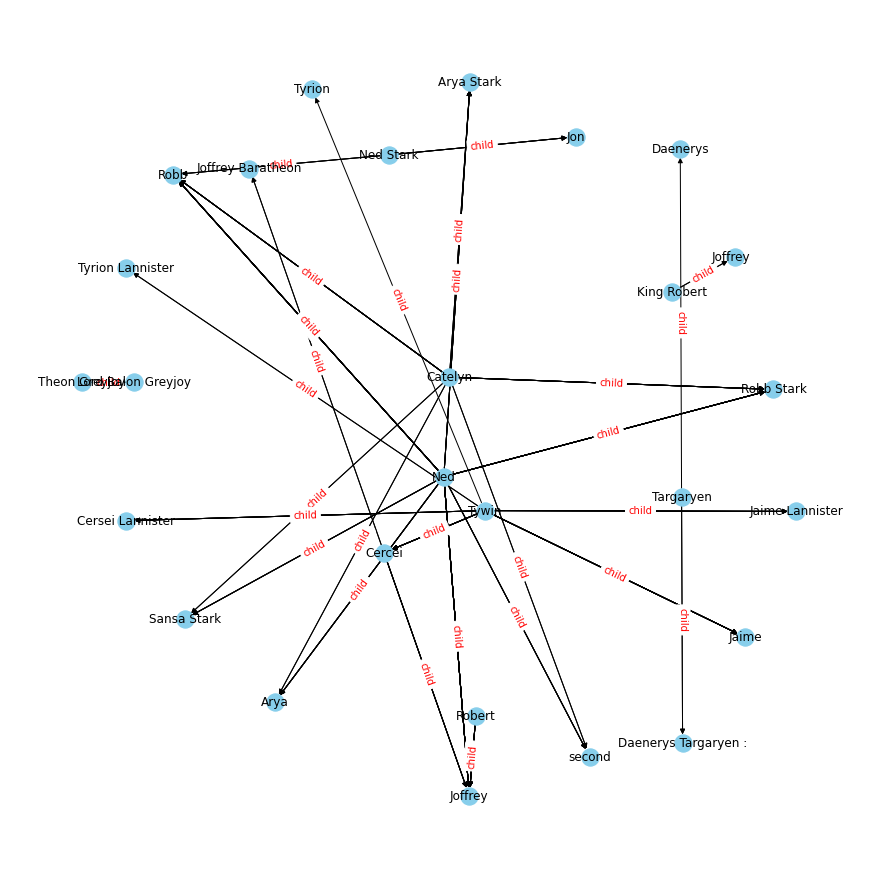

In [34]:
# Graph of children relationships
draw_relations(rel_type="child", pred_thresh=0.9)

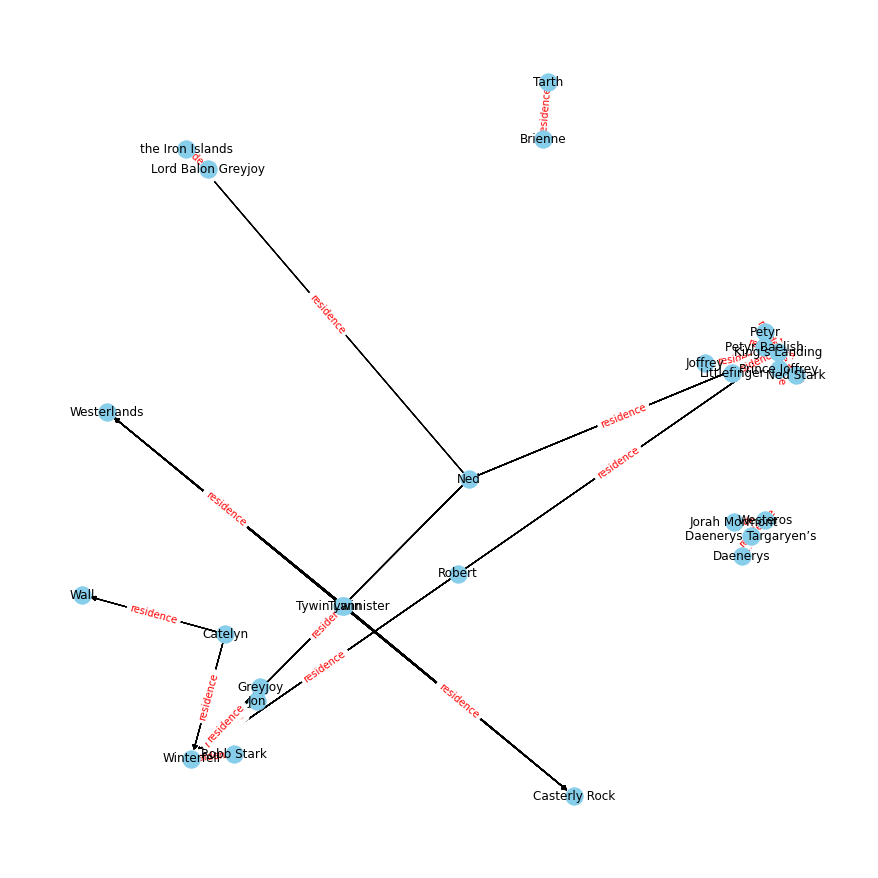

In [36]:
# Graph of where characters might reside
draw_relations(rel_type="residence", pred_thresh=0.7)

For those who are familiar with the story, most of these relationships will look accurate. The cleanliness of the KG
representation will largely depend on how well NER performs. As mentioned, we could improve the pipeline if we added coreference resolution and/or entity linking
to disambiguate entity names. Such techniques would help resolve multiple character aliases into a single entity.
For example, "Daenerys Targaryen" would resolve to her multiple aliases including "Daenarys Stormborn", "Khaleesi",
and "The Mother of Dragons", which would make for a tighter graph.

There are a number of other various end-to-end and modular approaches to deriving KG triples and KG completion.
The aim of this notebook was to demonstrate how one could build a simple pipeline using off-the-shelf libraries
to achieve this goal.